<a href="https://colab.research.google.com/github/saiful-kelubas-code/saiful_kelubas_DL/blob/main/BatikMotifs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
mkdir -p /content/batikmotifs

In [2]:
cp /content/drive/MyDrive/deep_learning/archive.zip /content/batikmotifs

In [ ]:
!unzip /content/batikmotifs/archive.zip -d /content/batikmotifs

In [12]:
import numpy as np 
import pandas as pd
images = []
label = []
import os
for dirname, _, filenames in os.walk('/content/batikmotifs/'):
    for filename in filenames:
        images.append(os.path.join(dirname, filename).split('/')[-1])
        label.append(os.path.join(dirname, filename).split('/')[-2])

In [13]:
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import time
from torch.nn import functional as F
from torchvision import models
import torch.nn as nn
import torch
import random
import PIL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
labels = np.unique(label)
ints = np.arange(0, len(label))
dicts = dict(zip(labels, ints))
dicts

{'batik-bali': 0,
 'batik-betawi': 1,
 'batik-celup': 2,
 'batik-cendrawasih': 3,
 'batik-ceplok': 4,
 'batik-ciamis': 5,
 'batik-garutan': 6,
 'batik-gentongan': 7,
 'batik-kawung': 8,
 'batik-keraton': 9,
 'batik-lasem': 10,
 'batik-megamendung': 11,
 'batik-parang': 12,
 'batik-pekalongan': 13,
 'batik-priangan': 14,
 'batik-sekar': 15,
 'batik-sidoluhur': 16,
 'batik-sidomukti': 17,
 'batik-sogan': 18,
 'batik-tambal': 19}

In [15]:
PATH = "/content/batikmotifs/"

df_full = pd.DataFrame({'image_id':images, 'label':label})

#FINDING BAD FILE

index = []
for i in range(len(df_full)):
    try:
        Image.open(PATH + str(df_full['label'].values[i]) + '/' + str(df_full['image_id'].values[i]))
    
    except PIL.UnidentifiedImageError:
        index.append(i)

df = df_full.drop(index)
df.head()

,image_id,label
0,42.jpg,batik-celup
1,32.jpg,batik-celup
2,49.jpg,batik-celup
3,21.jpg,batik-celup
4,8.jpg,batik-celup


<ipython-input-16-876953a842c9>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


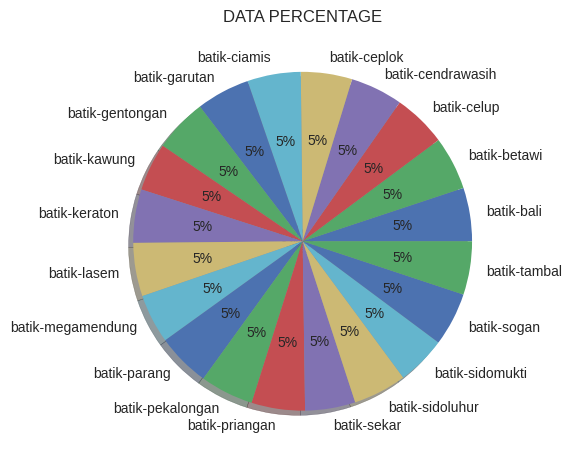

In [16]:
target, count = np.unique(df['label'], return_counts=True)
precentange = [x / np.sum(count) for x in count]
plt.style.use('seaborn')
plt.pie(precentange, labels = target,  autopct='%1.f%%', shadow=True)
plt.title('DATA PERCENTAGE')
plt.show()

In [17]:
class Batik(Dataset):
    def __init__(self, x, y, path, map_label=dicts, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.map_label = map_label
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.map_label[self.y[idx]]
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label

    def __len__(self):
        return len(self.X)
    
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df['image_id'].values, df['label'].values, 
    test_size=0.15, stratify=df['label'].values, 
    random_state=77)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, 
    stratify=y_trainval, test_size=0.15,
    random_state=77)


len(X_train), len(X_val), len(X_test)

(708, 125, 148)

In [18]:
mean= [0.485, 0.456, 0.406] 
std= [0.229, 0.224, 0.225]
batch_size = 24

train_transform = T.Compose([T.Resize((128, 128)),
                             T.RandomHorizontalFlip(),
                             T.RandomVerticalFlip(),
                             T.RandomRotation(20),
                             T.ToTensor(),
                             T.Normalize(mean, std)
                            ])

val_transform = T.Compose([T.Resize((128, 128)),
                           T.ToTensor(),
                           T.Normalize(mean, std),
                          ])

train_set = Batik(X_train, y_train, PATH, transform=train_transform)
val_set = Batik(X_val, y_val, PATH, transform=val_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
                                           num_workers=8, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False, 
                                         num_workers=8, pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


batik-megamendung


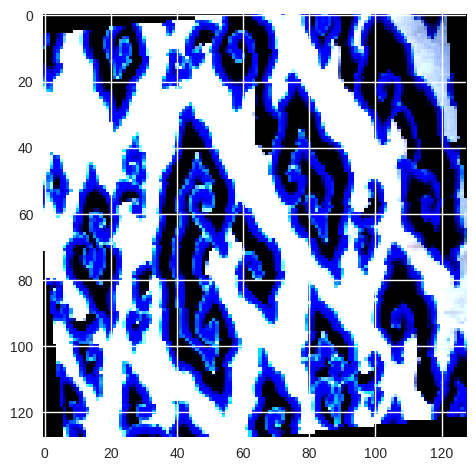

In [19]:
int_label = dict(zip(ints, labels))


img, label = train_set[random.randint(0, len(X_train))]
plt.imshow(img.permute(1,2,0));
print(int_label[label])

In [20]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=20, bias=True)
model

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
def accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

epoch = 20
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

In [22]:
train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []
for e in range(epoch):
    model.to(device)
    model.train()
    
    train_loss = 0
    train_acc = 0
    since = time.time()
    for image, label in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)
        
        train_loss += loss
        train_acc += accuracy(output, label)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    else:
        with torch.no_grad():
            model.eval()
            
            running_loss = 0
            val_accuracy =0
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                loss = criterion(output, label)
                val_accuracy += accuracy(output, label)
                running_loss += loss
                
    train_losses.append((train_loss/len(train_loader)).item())
    val_losses.append((running_loss/len(val_loader)).item())
    train_accuracy.append(train_acc/ len(train_loader))
    val_acc.append(val_accuracy/len(val_loader))
    
    print('epochs {}/{}..'.format(e+1, epoch),
          'train loss {:.3f}..'.format(train_loss/len(train_loader)),
          'val loss {:.3f}..'.format(running_loss/len(val_loader)),
          'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
          'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
          'time {:.3f} s'.format(time.time() - since)
         )

  0%|          | 0/30 [00:00<?, ?it/s]

epochs 1/20.. train loss 3.067.. val loss 2.734.. train accuracy 0.100.. val accuracy 0.176.. time 31.970 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 2/20.. train loss 2.297.. val loss 2.321.. train accuracy 0.347.. val accuracy 0.324.. time 32.893 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 3/20.. train loss 1.775.. val loss 2.289.. train accuracy 0.483.. val accuracy 0.381.. time 25.545 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 4/20.. train loss 1.815.. val loss 4.326.. train accuracy 0.449.. val accuracy 0.222.. time 29.412 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 5/20.. train loss 2.205.. val loss 4.131.. train accuracy 0.360.. val accuracy 0.194.. time 31.488 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 6/20.. train loss 2.292.. val loss 5.104.. train accuracy 0.353.. val accuracy 0.196.. time 28.509 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 7/20.. train loss 2.041.. val loss 2.450.. train accuracy 0.389.. val accuracy 0.369.. time 25.623 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 8/20.. train loss 1.557.. val loss 2.662.. train accuracy 0.533.. val accuracy 0.340.. time 31.158 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 9/20.. train loss 1.426.. val loss 2.774.. train accuracy 0.543.. val accuracy 0.365.. time 27.158 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 10/20.. train loss 1.221.. val loss 2.835.. train accuracy 0.622.. val accuracy 0.337.. time 35.427 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 11/20.. train loss 0.916.. val loss 2.935.. train accuracy 0.710.. val accuracy 0.367.. time 33.184 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 12/20.. train loss 0.708.. val loss 2.537.. train accuracy 0.778.. val accuracy 0.402.. time 27.896 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 13/20.. train loss 0.593.. val loss 2.644.. train accuracy 0.803.. val accuracy 0.420.. time 26.821 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 14/20.. train loss 0.421.. val loss 2.683.. train accuracy 0.865.. val accuracy 0.384.. time 29.442 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 15/20.. train loss 0.323.. val loss 2.781.. train accuracy 0.896.. val accuracy 0.402.. time 26.714 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 16/20.. train loss 0.219.. val loss 2.742.. train accuracy 0.935.. val accuracy 0.450.. time 29.267 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 17/20.. train loss 0.205.. val loss 2.782.. train accuracy 0.943.. val accuracy 0.432.. time 31.334 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 18/20.. train loss 0.179.. val loss 2.742.. train accuracy 0.944.. val accuracy 0.443.. time 28.279 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 19/20.. train loss 0.165.. val loss 2.749.. train accuracy 0.951.. val accuracy 0.398.. time 24.941 s


  0%|          | 0/30 [00:00<?, ?it/s]

epochs 20/20.. train loss 0.164.. val loss 2.721.. train accuracy 0.944.. val accuracy 0.420.. time 29.633 s


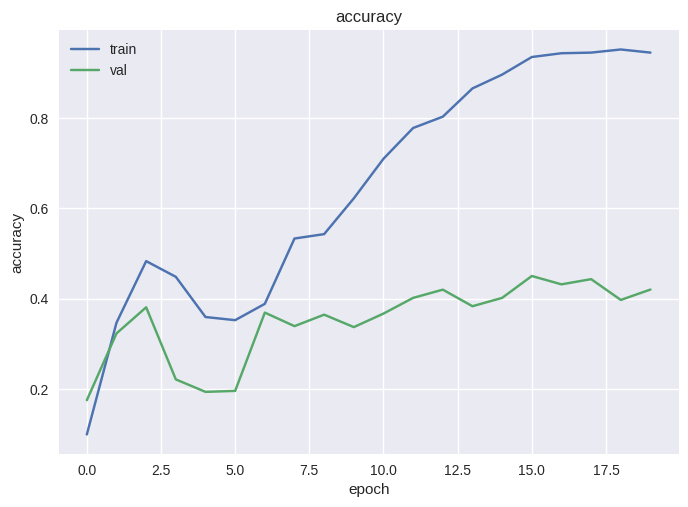

In [23]:
plt.plot(train_accuracy, label='train')
plt.title('accuracy')
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

In [24]:
test_set = Batik(X_test, y_test, PATH, transform=val_transform)

def predict(model, img, label):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

test_predict = []
true_label = []
for i in range(len(test_set)):
    img, label = test_set[i]
    prediction = predict(model, img, label)
    test_predict.append(prediction)
    true_label.append(label)

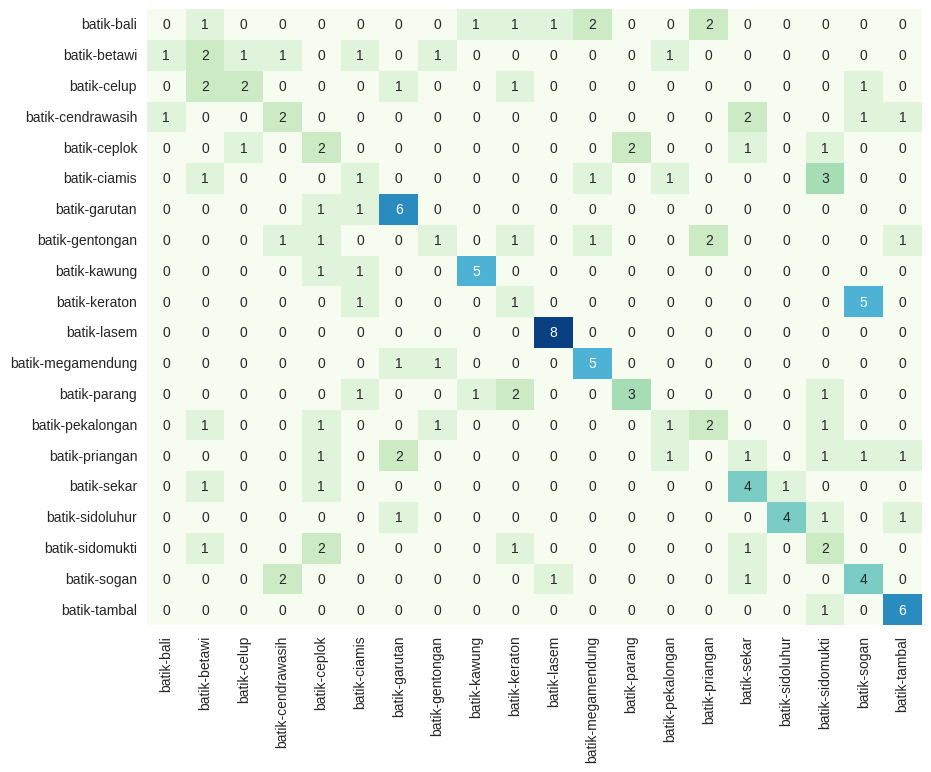

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(true_label, test_predict), annot=True, cmap='GnBu', cbar=False)
plt.xticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=90)
plt.yticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=0)
plt.show()

In [26]:
print(classification_report(true_label, test_predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.22      0.25      0.24         8
           2       0.50      0.29      0.36         7
           3       0.33      0.29      0.31         7
           4       0.20      0.29      0.24         7
           5       0.17      0.14      0.15         7
           6       0.55      0.75      0.63         8
           7       0.25      0.12      0.17         8
           8       0.71      0.71      0.71         7
           9       0.14      0.14      0.14         7
          10       0.80      1.00      0.89         8
          11       0.56      0.71      0.63         7
          12       0.60      0.38      0.46         8
          13       0.25      0.14      0.18         7
          14       0.00      0.00      0.00         8
          15       0.40      0.57      0.47         7
          16       0.80      0.57      0.67         7
          17       0.18    

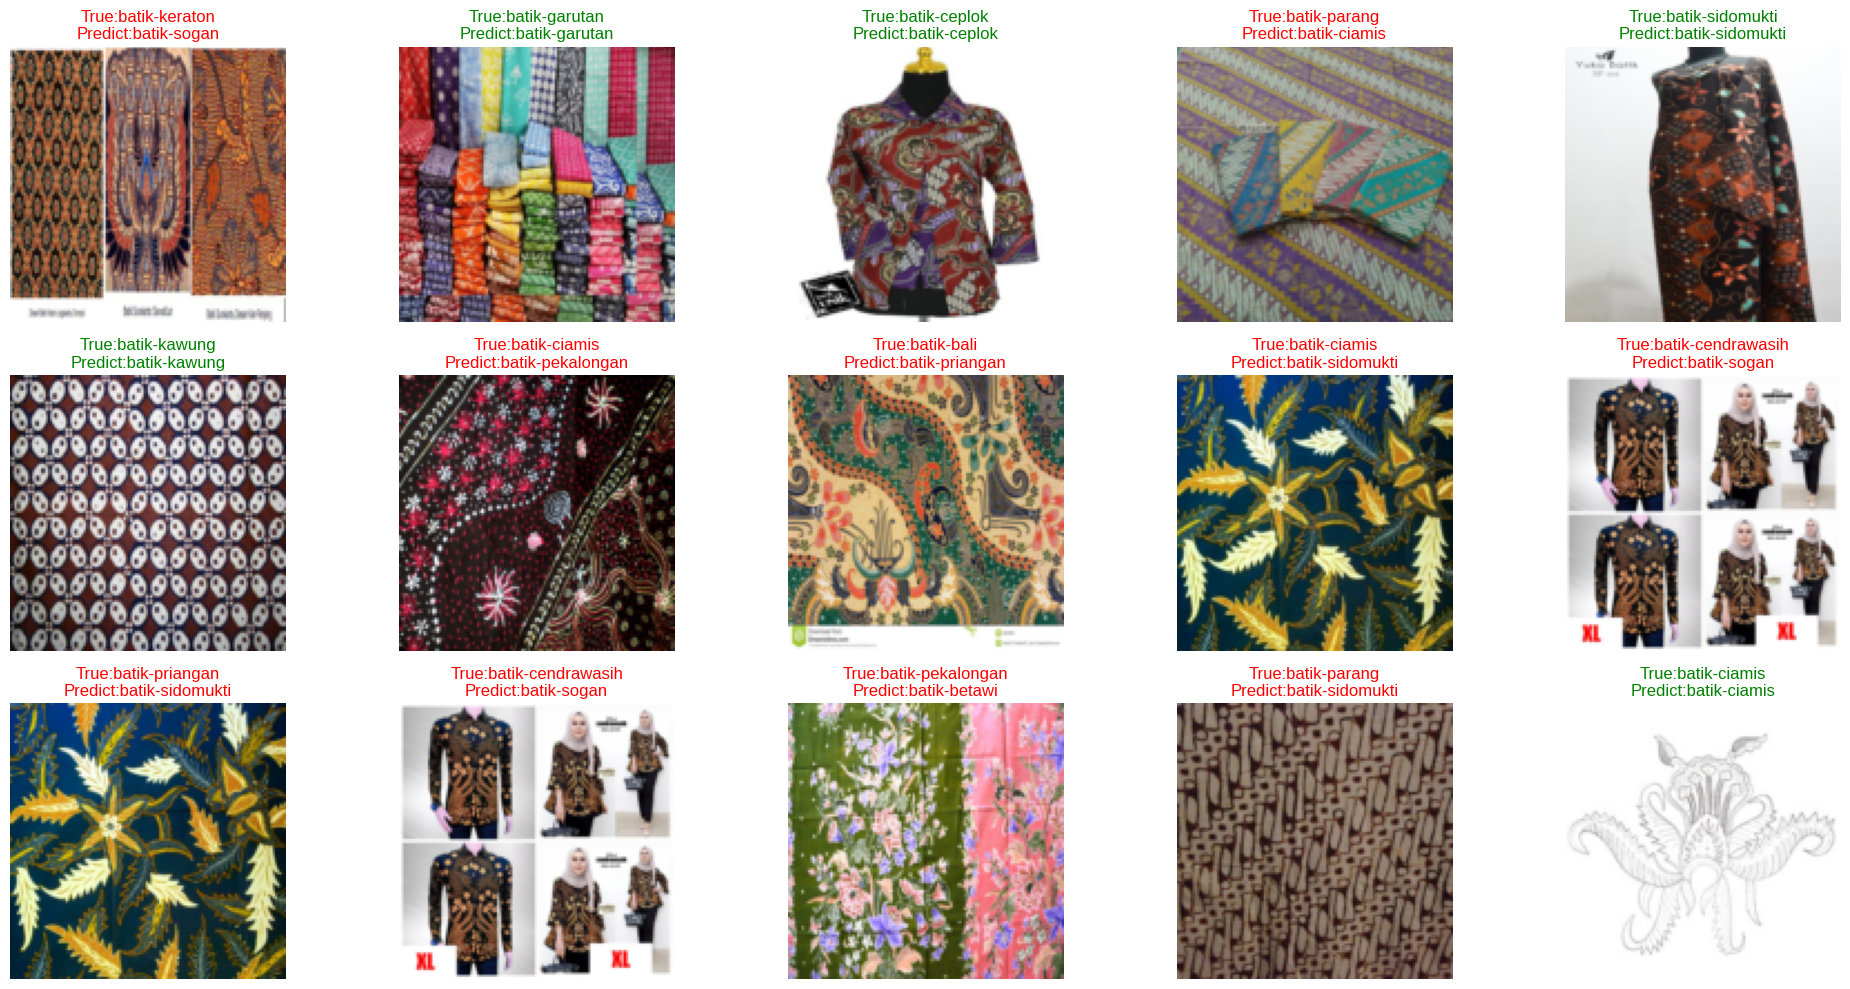

In [27]:
random_selection = np.random.randint(0, len(test_predict), 15)

fig = plt.figure(figsize=(20, 10))

test_set = Batik (X_test, y_test, PATH, transform=T.Resize((124,124)))
for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks = [])
    ax.imshow(image)
    ax.set_title('True:{}\nPredict:{}'.format(int_label[label], int_label[test_predict[idx]]),
                color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

plt.tight_layout()
plt.show()